# Base Random Forest for Audio Classification- Split by Gender

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
import sklearn as sk
from sklearn.ensemble import RandomForestClassifier


%matplotlib inline

## Read in data and setup Dataframe

In [3]:
audio_data = np.load("audio_data.npy")
labels = np.load("wav_labels.npy")

# labels: modality-vocal channel-emotion-emotional intensity-statement-repetition-actor
# emotions: 01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised
# odd number actors = male, even = female

# 1440 files: 24 speakers, 60 recordings per speaker
audio_data = audio_data.reshape(1440, 9480)

m_features = []
f_features = []


# classifying by emotion when segmented by gender
for i in range(1440):
    
    if (labels[i][6]%2 == 0):
        label = "Female"
    else:
        label = "Male"
        
    if (labels[i][2] == 1):
        emot = "neutral"
    elif (labels[i][2] == 2):
        emot = "calm"
    elif (labels[i][2] == 3):
        emot = "happy"
    elif (labels[i][2] == 4):
        emot = "sad"
    elif (labels[i][2] == 5):
        emot = "angry"
    elif (labels[i][2] == 6):
        emot = "fearful"
    elif (labels[i][2] == 7):
        emot = "disgust"
    elif (labels[i][2] == 8):
        emot = "surprised"
    
    if (label == "Male"):
        m_features.append([audio_data[i], label, emot])
    elif (label == "Female"):
        f_features.append([audio_data[i], label, emot])
    


    
m_feature_df = pd.DataFrame(m_features, columns = ["mfcc", "gender", "emotion"])
f_feature_df = pd.DataFrame(f_features, columns = ["mfcc", "gender", "emotion"])


m_feature_df.head()

,mfcc,gender,emotion
0,"[-855.3770751953125, -855.3770751953125, -855....",Male,neutral
1,"[-850.3917236328125, -850.435791015625, -850.4...",Male,neutral
2,"[-849.78369140625, -848.8447265625, -848.56610...",Male,neutral
3,"[-842.9385375976562, -843.2474975585938, -850....",Male,neutral
4,"[-911.1758422851562, -910.4053344726562, -905....",Male,calm


In [4]:
f_feature_df.head()

,mfcc,gender,emotion
0,"[-821.495849609375, -821.495849609375, -821.49...",Female,neutral
1,"[-820.0106811523438, -820.0106811523438, -820....",Female,neutral
2,"[-782.8099365234375, -782.8099365234375, -782....",Female,neutral
3,"[-814.5337524414062, -813.1904907226562, -812....",Female,neutral
4,"[-853.9297485351562, -853.9297485351562, -853....",Female,calm


## Breakdown Dataframe and run through Random Forest

In [6]:
X_m = np.array(m_feature_df.mfcc.tolist())
X_f = np.array(f_feature_df.mfcc.tolist())

Y_m = np.array(m_feature_df.emotion.tolist())
Y_f = np.array(f_feature_df.emotion.tolist())

x_train, x_test, y_train, y_test = sk.model_selection.train_test_split(X_m, Y_m, test_size=0.25, random_state=0)

X_train, X_test, Y_train, Y_test = sk.model_selection.train_test_split(X_f, Y_f, test_size=0.25, random_state=0)

# Standard RF
rfc_m = RandomForestClassifier()

rfc_m.fit(x_train, y_train)

predictions_m = rfc_m.predict(x_test)

rfc_f = RandomForestClassifier()

rfc_f.fit(X_train, Y_train)

predictions_f = rfc_f.predict(X_test)

## Display Results: Confusion Matrices

Emotion Classification among Male Subjects
   neutral  calm  happy  sad  angry  fearful  disgust  surprised
0       11     2      2    0      2        0        0          1
1        0    18      2    0      0        4        3          0
2        0     1     16    0      1        0        1          0
3        3     3      2    7      2        1        2          2
4        8     2      1    1     11        0        2          2
5        0     2      1    1      0        4        8          0
6        1     7      2    0      2        0       12          1
7        0     1      5    5      3        0        1         11


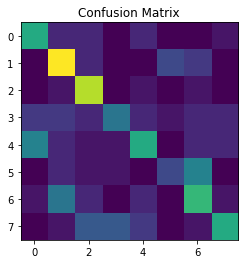

Emotion Classification among Female Subjects
   neutral  calm  happy  sad  angry  fearful  disgust  surprised
0       11     0      1    2      0        0        0          4
1        0    13      6    0      0        4        2          2
2        1     2     13    0      0        0        2          1
3        2     3      0   11      0        0        1          5
4        4     1      1    3      8        0        1          9
5        0     3      0    0      0        9        2          2
6        3     6      3    1      1        3        6          2
7        0     1      1    0      1        1        1         21


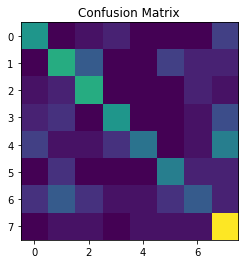

In [9]:
cm_m = sk.metrics.confusion_matrix(y_test, predictions_m)
cm_f = sk.metrics.confusion_matrix(Y_test, predictions_f)

print("Emotion Classification among Male Subjects")
df = pd.DataFrame(cm_m, columns=[Y_m[0], Y_m[4], Y_m[12], Y_m[20], Y_m[28], Y_m[36], Y_m[44], Y_m[52] ])
print(df)

plt.figure(figsize=(10,4))
plt.imshow(cm_m)
plt.title("Confusion Matrix")
plt.show()

print("Emotion Classification among Female Subjects")
df = pd.DataFrame(cm_f, columns=[Y_f[0], Y_f[4], Y_f[12], Y_f[20], Y_f[28], Y_f[36], Y_f[44], Y_f[52] ])
print(df)

plt.figure(figsize=(10,4))
plt.imshow(cm_f)
plt.title("Confusion Matrix")
plt.show()

## Precision Results

In [10]:
def precision(confmatrix):
    # precision = tp/(tp+fp)
    tp = np.diag(confmatrix)
    fp = np.sum(confmatrix, axis=0) - tp
    precision = np.mean(tp/(tp+fp))
    return precision

prec_m = precision(cm_m)
prec_f = precision(cm_f)

print("Classification by Emotion Precision in Males: " + str(prec_m))
cr = sk.metrics.classification_report(y_test, predictions_m)
print(cr)

print("Classification by Emotion Precision in Females: " + str(prec_f))
cr = sk.metrics.classification_report(Y_test, predictions_f)
print(cr)

Classification by Emotion Precision in Males: 0.5029369746318673
              precision    recall  f1-score   support

       angry       0.48      0.61      0.54        18
        calm       0.50      0.67      0.57        27
     disgust       0.52      0.84      0.64        19
     fearful       0.50      0.32      0.39        22
       happy       0.52      0.41      0.46        27
     neutral       0.44      0.25      0.32        16
         sad       0.41      0.48      0.44        25
   surprised       0.65      0.42      0.51        26

    accuracy                           0.50       180
   macro avg       0.50      0.50      0.48       180
weighted avg       0.51      0.50      0.49       180

Classification by Emotion Precision in Females: 0.5406347141555272
              precision    recall  f1-score   support

       angry       0.52      0.61      0.56        18
        calm       0.45      0.48      0.46        27
     disgust       0.52      0.68      0.59        19
